In [1]:
print('Hello, world!')

Hello, world!


In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
import warnings
from add_drive_cost import *

warnings.filterwarnings("ignore")


rd = pd.read_csv('rides.csv', sep=',', skipinitialspace=True)
wt = pd.read_csv('weather.csv', sep=',', skipinitialspace=True)
rd.columns = [i.lower().replace(' ', '_') for i in rd.columns]
wt.columns = [i.lower().replace(' ', '_') for i in wt.columns]
rd.end_date = pd.to_datetime(rd.end_date.astype(str).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if len(x) == 19 else pd.NA))
rd.start_date = pd.to_datetime(rd.start_date.astype(str).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if len(x) == 19 else pd.NA))
wt.datetime = wt.datetime.astype(str).apply(lambda x: dt.datetime.strptime(x.replace(' ', 'T'), '%Y-%m-%dT%H:%M:%S') if len(x) == 19 else pd.NA)
rd.drop_duplicates(subset=['id'], keep='first', inplace=True)

In [ ]:
for i in rd.columns[4:8]:
    rd.loc[:, i] = rd[i].astype(str).apply(lambda x: x.lower().replace(' ', '_'))

# Предобработка данных, очистка от выбросов и заполнение пропусков
#### Для начала найдём средние значения времени поездки, скорости, расстояния и т.п. для дальнейшего заполнения пропусков

In [ ]:
rd1 = rd.copy()

In [ ]:
rd1['duration_sec'] = (rd1['end_date'] - rd1['start_date']).dt.total_seconds()
rd1['duration_sec'] = rd1.duration_sec.where(rd1.duration_sec <= 1000000, pd.NA).dropna()

In [ ]:
rd1['speed'] = (rd1.loc[:, 'distance'] / rd1.loc[:, 'duration_sec']).astype(float)
rd1['speed'] = rd1['speed'].where(rd1['speed'] <= 1000, pd.NA).dropna()  # находим скорость и ограничиваем экстремальные выбросы

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.violinplot(rd1.speed, orient='h', ax=axes[0])
sns.boxplot(rd1.speed, orient='h', ax=axes[1])
plt.xlabel('speed - Средняя скорость поездки')
print(rd1.speed.quantile(0.25) - 1.5 * (rd1.speed.quantile(0.75) - rd1.speed.quantile(0.25)))
print(min(rd1.speed), max(rd1.speed))
rd1

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
rd1.loc[:, 'speed_var'] = rd1.speed.apply(lambda x: 'low' if x <= 0.9336 else 'normal')
sns.kdeplot(data=rd1, x='duration_sec', hue='speed_var', ax=axes[0])
sns.kdeplot(data=rd1, x='distance', hue='speed_var', ax=axes[1])
sns.kdeplot(data=rd1[rd1['speed'] >= 1], x='distance', ax=axes[2])
max(rd1.speed)

#### 5.31 м/с = 19.116 км/ч - вполне реальная величина скорости для самокатов, это намного ниже максимальной скорости большинства электросамокатов, а вот скорости, очень близкие к нулю - подозрительны, однако могут объясняться слишком большой продолжительностью поездки

In [ ]:
sns.scatterplot(data=rd1, x='duration_sec', y='speed')

In [ ]:
sns.scatterplot(data=rd1, x='distance', y='duration_sec')

In [ ]:
rd1[rd1['speed_var'] == 'low']

In [ ]:
rd1['go'] = rd1.loc[:, 'end_location'] + rd1.loc[:, 'end_district'] + rd1.loc[:, 'end_location'] + rd1.loc[:, 'end_district']
rd1['time_quantile'] = pd.qcut(rd1['duration_sec'], q=10, labels=range(1, 11))
mask = rd1['speed'] < 0.9336

rd1.loc[mask, 'speed'] = rd1.groupby(['go', 'time_quantile'])['speed'].transform('mean')

rd1['speed'] = rd1['speed'].fillna(rd1.groupby(['go', 'time_quantile'])['speed'].transform('mean'))

rd1['speed'] = rd1['speed'].fillna(rd1.groupby('go')['speed'].transform('mean'))  # Заполняем значения для поездок, у которых нет большого кол-ва квантилей

rd1.loc[:, 'speed_var'] = rd1.speed.apply(lambda x: 'low' if x <= 0.9336 else 'normal')
sns.scatterplot(data=rd1, x='duration_sec', y='speed')
rd1[rd1['speed_var'] == 'low']

#### ...

In [ ]:
sns.kdeplot(data=rd1[rd1['distance'] < 100000], x='distance')

#### Скорее всего, поездки состоялись, но на определённых отрезках расстояние фиксируется неправильно, поэтому для заполнения пропусков в расстоянии мы будем использовать средние значения скорости по пунктам поездки (если будем использовать для заполнения общую среднюю скорость, то получим неправильные значения времени для отрезков с низкой скоростью).

In [ ]:
sns.violinplot(rd1.duration_sec)
min(rd1.duration_sec.where(rd1.duration_sec >= 0).dropna())

In [ ]:
import numpy as np

# Calculate duration_sec based on speed if it is missing
rd1['duration_sec'] = rd1['duration_sec'].fillna(rd1['distance'] / rd1['speed'])
rd1['distance'] = rd1['distance'].fillna(rd1.speed * rd1.duration_sec)

# Fill in end_date based on start_date and duration_sec
rd1['end_date'] = rd1['start_date'] + pd.to_timedelta(rd1['duration_sec'], unit='s')

In [ ]:
rd1

In [ ]:
rd1.info()

In [ ]:
rd1['distance_diff'] = rd1.distance - (rd1.speed * rd1.duration_sec)
rd1

In [ ]:
rd1.where(rd1.distance_diff > 10).dropna()

In [ ]:
rd1.where(rd1.distance_diff > 10).dropna().distance_diff.min()

#### Видно, что самое маленькое отклонение зафиксированной дистанции и дистанции, которая посчитана через скорость и время - больше 1000км (а также самая минимальная дистанция в этой таблице - 1019км), а значит зафиксированные дистанции неверны

In [ ]:
mask = (rd1.distance_diff > 10) | (rd1.distance > 1000000)
rd1.loc[mask, 'distance'] = rd1.loc[mask, 'speed'] * rd1.loc[mask, 'duration_sec']
rd1

In [ ]:
rd1['distance_diff'] = rd1.distance - (rd1.speed * rd1.duration_sec)
print(rd1.where(rd1.distance_diff > 10).dropna())

In [ ]:
sns.scatterplot(data=rd1, x='distance', y='duration_sec')

In [ ]:
rd1.distance.max()

In [ ]:
rd1.where(rd1.distance == rd1.distance.max()).dropna()

In [ ]:
Q1_dis = rd1.distance.quantile(0.25) - 1.5 * (rd1.distance.quantile(0.75) - rd1.distance.quantile(0.25))
rd1[rd1.distance < Q1_dis]

#### Видно, что значение по скорости и времени сильно различаются с зафиксированными значениями (столбец distance_diff), скорее всего зафиксированное значение неверно - рассмотрим их

In [ ]:
mask = (rd1.distance < Q1_dis) | (rd1.distance > 1000000)
rd1.loc[mask, 'distance'] = rd1.groupby('go')['distance'].transform('mean')
rd1.loc[mask, 'duration_sec'] = rd1.groupby('go')['duration_sec'].transform('mean')
sns.scatterplot(data=rd1, x='distance', y='duration_sec')

In [ ]:
rd1[rd1.duration_sec > 1000000]

In [ ]:
rd1.to_csv('rides_final.csv')

# Очистим от выбросов и пропусков weather

In [3]:
wt1 = wt.drop(wt.index[0]).copy()

In [4]:
wt1[wt1.temperature.isnull()]

,unnamed:_0,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
363,363,2023-04-16 02:00:00,NaN,0.3,13.32,3.671294,100,0
364,364,2023-04-16 03:00:00,NaN,0.4,13.32,4.452954,98,0
365,365,2023-04-16 04:00:00,NaN,0.4,13.32,4.802999,100,0
366,366,2023-04-16 05:00:00,NaN,0.3,13.679999,4.379589,100,0
367,367,2023-04-16 06:00:00,NaN,0.2,14.4,5.0528407,100,0
368,368,2023-04-16 07:00:00,NaN,0.3,15.4800005,6.379216,100,0
369,369,2023-04-16 08:00:00,NaN,0.2,19.08,9.957108,100,0
370,370,2023-04-16 09:00:00,NaN,0.2,24.48,10.383987,100,0
371,371,2023-04-16 10:00:00,NaN,0.2,24.48,7.7043357,100,0
372,372,2023-04-16 11:00:00,NaN,0.3,24.84,8.534353,91,4.8484864


In [5]:
wt1.dropna(subset=['temperature'], how='all').loc[wt1.drop(columns='temperature').isnull().any(axis=1)]

,unnamed:_0,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
935,935,2023-05-09 22:00:00,13.900246,0.5,30.960001,NaN,94,0
936,936,2023-05-09 23:00:00,13.780245,0.1,30.599998,NaN,76,0
937,937,2023-05-10 00:00:00,13.490245,0,31.68,NaN,91,0
938,938,2023-05-10 01:00:00,13.290245,0,33.839996,NaN,62,0
1296,1296,2023-05-24 23:00:00,10.470245,0,23.039999,NaN,57,0
...,...,...,...,...,...,...,...,...
2792,2792,2023-07-26 07:00:00,14.240245,0.5,23.4,8.404285,NaN,7.2727275
2841,2841,2023-07-28 08:00:00,23.130245,0,27.359999,11.480557,29,NaN
2842,2842,2023-07-28 09:00:00,24.820246,0,29.519999,13.18308,42,NaN
2843,2843,2023-07-28 10:00:00,25.320246,0,39.96,15.807239,40,NaN


#### Видно, что есть достаточно много пустых значений, стоящих рядом, поэтому заполнять будем регрессией, а не интерполяцией или по соседним значениям

In [6]:
wt1['datetime'] = pd.to_datetime(wt1['datetime'])
wt1['day'] = wt1['datetime'].dt.day
wt1['hour'] = wt1['datetime'].dt.hour
wt1['month'] = wt1['datetime'].dt.month
wt1['hour_total'] = wt1['datetime'].dt.hour + wt1.datetime.dt.dayofyear * 24
bins = [-1, 6, 12, 18, 23]

from sklearn.preprocessing import OneHotEncoder

# Categorize the 'hour' column into specific labels
labels = ['night', 'morning', 'evening', 'afternoon']
wt1['hour_category'] = pd.cut(wt1['hour'], bins=bins, labels=labels, right=False, ordered=False)

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'hour_category' column
hour_category_encoded = encoder.fit_transform(wt1[['hour_category']].astype(str))

# Convert the encoded data into a DataFrame
hour_category_encoded_df = pd.DataFrame(hour_category_encoded.toarray(), columns=encoder.get_feature_names_out(['hour_category']))

# Concatenate the encoded hour category data with the original data
wt1 = pd.concat([wt1, hour_category_encoded_df], axis=1)

# Drop the original 'hour_category' column
wt1 = wt1.drop('hour_category', axis=1)

In [7]:
# Map months to seasons
month_to_season = {1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 6: 'summer', 7: 'summer', 8: 'summer', 9: 'fall', 10: 'fall', 11: 'fall', 12: 'winter'}

# Replace 'month' column with 'season'
wt1['season'] = wt1['month'].map(month_to_season)

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'season' column
season_encoded = encoder.fit_transform(wt1[['season']])

# Convert the encoded data into a DataFrame
season_encoded_df = pd.DataFrame(season_encoded.toarray(), columns=encoder.get_feature_names_out(['season']))

# Concatenate the encoded season data with the original data
wt1 = pd.concat([wt1, season_encoded_df], axis=1)

# Drop the original 'season' column
wt1 = wt1.drop('season', axis=1)

In [8]:
wt1.columns

Index(['unnamed:_0', 'datetime', 'temperature', 'precipitation_total',
       'wind_gust', 'wind_speed', 'cloud_cover_total', 'sunshine_duration',
       'day', 'hour', 'month', 'hour_total', 'hour_category_afternoon',
       'hour_category_evening', 'hour_category_morning', 'hour_category_nan',
       'hour_category_night', 'season_spring', 'season_summer', 'season_nan'],
      dtype='object')

In [25]:
wt1.corr().to_excel('aaa.xlsx')

Рассмотрим самые сильные корреляции: 
Влияние даты на температуру и время солнечного света объясняется тем, что в датасете данные с середины весны и до августа - в период, когда средняя температура возрастает, а время солнечного света увеличивается к лету.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Separate data with and without missing temperature values
train_data = wt1.dropna(subset=['temperature'])

# Define the features and target
X = train_data['precipitation_total,wind_gust,cloud_cover_total,sunshine_duration,day,hour,month,season_spring,season_summer,hour_category_night,hour_category_morning,hour_category_evening,hour_category_afternoon,hour_total'.split(',')]  # Specify your features
y = train_data['temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_pipeline(SimpleImputer(), LinearRegression())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

if mse > 0.5 or r2 < 0.5:
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    features_for_prediction = ['precipitation_total', 'wind_gust', 'cloud_cover_total', 'sunshine_duration',
                               'day', 'hour', 'month', 'season_spring', 'season_summer',
                               'hour_category_night', 'hour_category_morning', 'hour_category_evening', 'hour_category_afternoon', 'hour_total']

# Make predictions for all values in the DataFrame using the selected features
    all_predictions = model.predict(wt1[features_for_prediction])

# Store the predictions in the 'temperature_predictions' column
    wt1['temperature_predictions'] = all_predictions

else:
    # Predict missing values
    X_missing = wt1.loc[wt1['temperature'].isnull(), ['precipitation_total,wind_gust,cloud_cover_total,sunshine_duration,day,hour,month,season_spring,season_summer,hour_category_night,hour_category_morning,hour_category_evening,hour_category_afternoon'.split(',')]]
    predicted_temperatures = model.predict(X_missing)

    # Fill in the missing temperature values
    wt1.loc[wt1['temperature'].isnull(), 'temperature'] = predicted_temperatures


wt1['temperature_interpolated'] = wt1['temperature'].interpolate(method='quadratic', limit=100)

Mean Squared Error: 11.952225916284547
R-squared Score: 0.7483157520461342


In [14]:
rows_with_missing_temp = wt1[wt1['temperature'].isnull()]

# Include neighboring days (e.g., previous and next rows) for each row with missing 'temperature'
neighboring_rows = wt1.loc[rows_with_missing_temp.index - 1].append(wt1.loc[rows_with_missing_temp.index]).append(wt1.loc[rows_with_missing_temp.index + 24])

# Display the rows with missing 'temperature' and neighboring days
print(neighboring_rows)

KeyError: '[-1] not in index'

In [15]:
print(len(wt1.hour_total.unique()), len(wt1))

3673 3673


<Axes: xlabel='datetime', ylabel='temperature_predictions'>

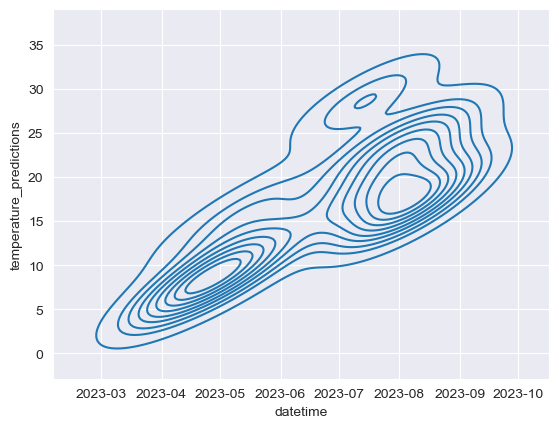

In [23]:
sns.kdeplot(data=wt1[wt1['temperature'].isnull()], x='datetime', y='temperature_predictions')

In [ ]:
wt1[wt1.temperature_predictions.isnull()]

In [ ]:
wt1.to_csv('kpolyakov.spb.csv')